In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation, get_body

from pint.fitter import WLSFitter
from pint.config import runtimefile
from pint.residuals import Residuals
from pint.observatory import get_observatory
from pint.models import get_model_and_toas, parameter
from astropy.coordinates import Angle, SkyCoord, EarthLocation, GCRS

import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [3]:
# fitting example for 1 stride
toafile = './timing_data/B0531+21.toa'     # data from Jodrell Bank Observatory
modelfile = './timing_data/crab_model.par' # data from ATNF Pulsar Catalogue 
tm, toas = get_model_and_toas(modelfile, toafile)
print(toas.print_summary())  # print summary of toas
tm                           # print summary of fitting model 

WARNING  (pint.observatory.clock_file   ): Data points out of range in clock file 'C:\Users\Robert\anaconda3\lib\site-packages\pint\data\runtime\time_jb.dat'
WARNING  (pint.observatory.clock_file   ): Data points out of range in clock file 'C:\Users\Robert\anaconda3\lib\site-packages\pint\data\runtime\gps2utc.clk'
WARNING  (pint.observatory.clock_file   ): Data points out of range in clock file 'C:\Users\Robert\anaconda3\lib\site-packages\pint\data\runtime\tai2tt_bipm2019.clk'


Number of TOAs:  7172
Number of commands:  1
Number of observatories: 1 ['jodrell']
MJD span:  55889.859 to 59889.307
Date span: 2011-11-24 20:37:00.043571341 to 2022-11-06 07:21:29.935751244
jodrell TOAs (7172):
  Min freq:      610.000 MHz
  Max freq:      611.000 MHz
  Min error:     1.21 us
  Max error:     159 us
  Median error:  4.19 us

None


TimingModel(
  AstrometryEquatorial(
    MJDParameter(   POSEPOCH            0.0000000000000000 (d) frozen=True),
    floatParameter( PX                  0.511             (mas) +/- 0.078 mas frozen=True),
    AngleParameter( RAJ                 5:34:31.97200000  (hourangle) frozen=True),
    AngleParameter( DECJ                22:00:52.07000000 (deg) frozen=True),
    floatParameter( PMRA                -11.513           (mas / yr) +/- 0.098 mas / yr frozen=True),
    floatParameter( PMDEC               2.302             (mas / yr) +/- 0.064 mas / yr frozen=True)),
  DispersionDM(
    floatParameter( DM                  56.77             (pc / cm3) +/- 0.00024 pc / cm3 frozen=True),
    floatParameter( DM1                 UNSET,
    MJDParameter(   DMEPOCH             56703.0000000000000000 (d) frozen=True)),
  SolarSystemShapiro(
    boolParameter(  PLANET_SHAPIRO      N                 frozen=True)),
  Spindown(
    floatParameter( F0                  0.0               (Hz) frozen=T

In [12]:
t1 = Time('2017-09-10', format='iso').mjd
t2 = Time('2017-09-19', format='iso').mjd
toas_window = toas[(toas.get_mjds().value > t1) & (toas.get_mjds().value < t2)] # toasa between t1 & t2

# initial guesses
tm.F0.value, tm.F0.frozen = 29.6383907, False
tm.F1.value, tm.F1.frozen = -3.68657e-10, False
tm.F2.value, tm.F2.frozen = 1.16e-20, True
tm.POSEPOCH.value, tm.PEPOCH.value = 58012.000000349, 58012.000000349

tm.validate()
Residuals(toas_window, tm).chi2_reduced # initial reduced chi^2

15931.836759817068

In [13]:
# run fit 
f = WLSFitter(toas_window, tm,track_mode='nearest')
f.fit_toas()
f.print_summary()

Fitted model using weighted_least_square method with 2 free parameters to 17 TOAs
Prefit residuals Wrms = 418.91113290304065 us, Postfit residuals Wrms = 4.156531534841586 us
Chisq = 21.959 for 14 d.o.f. for reduced Chisq of 1.568

PAR                   Prefit                  Postfit            Units
============== ==================== ============================ =====
PSR                      J0534+2200 J0534+2200                   None
EPHEM                         DE440 DE440                        None
CLOCK                               TT(BIPM2019)                 None
UNITS                           TDB TDB                          None
START                                                    58006.2 d 
FINISH                                                   58014.4 d 
DILATEFREQ                        N                              None
DMDATA                            N                              None
NTOA                              0                              None 

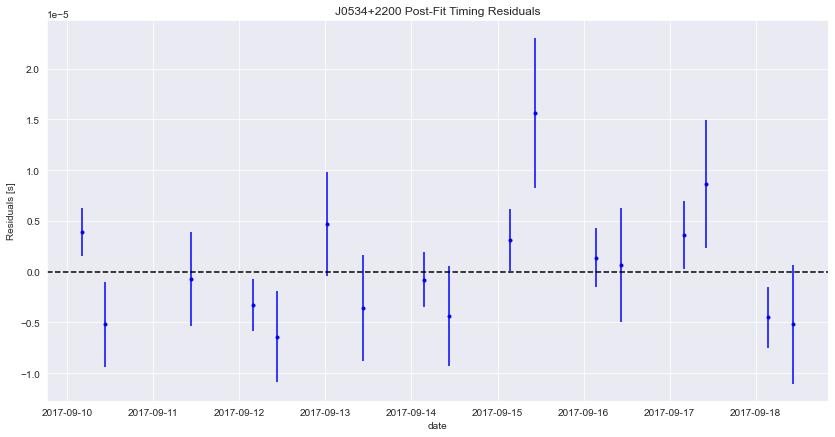

In [56]:
fig, ax = plt.subplots(figsize=(14, 7))
xt_ = Time(toas_window.get_mjds(), format='mjd').datetime
ax.errorbar(xt_, f.resids.time_resids, yerr=toas_window.get_errors().to(u.s), fmt='b.')
ax.set_title(f'{tm.PSR.value} Post-Fit Timing Residuals')
ax.set_xlabel('date')
ax.set_ylabel('Residuals [s]')
ax.axhline(0, ls='--', c='k')

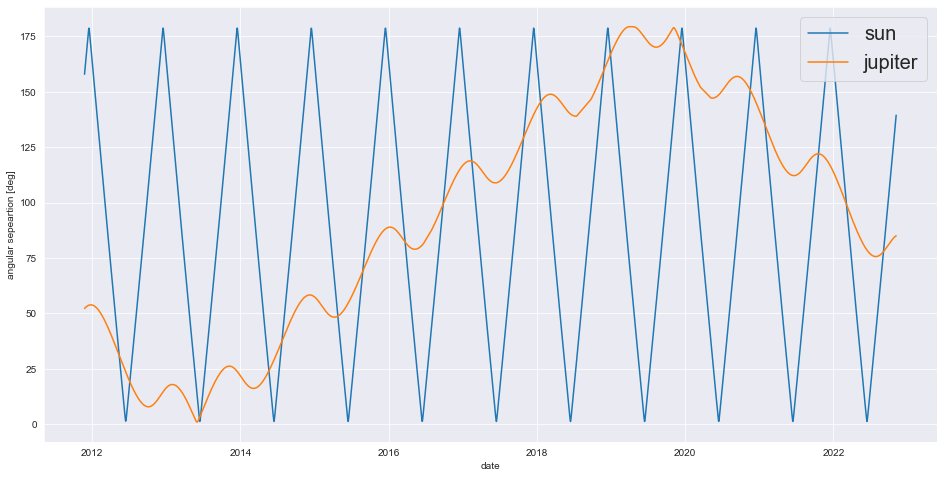

In [20]:
# calculating angular separation between Sun/Jupiter from Crab pulsar as seen from Jodrell Bank Obseravtory.
# Both objects are potential sources for radio wave interference
times = Time(toas.get_mjds().value, format='mjd')
jb42 =  EarthLocation(get_observatory('jb42').earth_location_itrf()) # telescope used
solar_system_ephemeris.set('de432s') # accurate between 1950 to 2050

sun_loc = get_body('sun', times, jb42)
jupiter_loc = get_body('jupiter', times, jb42)

coords = np.array([3822294.825, -153862.275, 5085987.071]) # coordinates of JB-42ft telescope
crab_loc = GCRS(83.63311446*u.deg, 22.01448714*u.deg, obsgeoloc=np.array(coords)*u.m)
peak_loc, peaks = find_peaks(180-crab_loc.separation(sun_loc).value, height=175, width=100)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(times.datetime, crab_loc.separation(sun_loc).value, label='sun')
ax.plot(times.datetime, crab_loc.separation(jupiter_loc).value, label='jupiter')
ax.set_ylabel('angular sepeartion [deg]')
ax.set_xlabel('date')
ax.legend(fontsize=20)

In [34]:
class PulsarTiming: # class for performing stride fits
    def __init__(self, parfile, timfile, emphfile):
        (self.tm, self.all_toas) = get_model_and_toas(parfile, timfile)
        self.em_df = pd.read_csv(emphfile)
        self.time_ = []
        self.resids_ = []
        self.resids_err_ = []
        self.omega = []
    
    def __str__(self):
        self.all_toas.print_summary()
        print(str(self.tm))
    
    def get_toas(self, start, end):
        vals = self.all_toas.get_mjds().value
        return self.all_toas[(vals >= start) & (vals <= end)]
        
    def fit_window(self, start, end, params):
        F0, F1, F2, PEPOCH = params
        self.tm.F0.value, self.tm.F1.value, self.tm.F2.value = F0, F1, F2
        self.tm.F0.frozen, self.tm.F1.frozen, self.tm.F2.frozen = False, False, True
        self.tm.PEPOCH.value, self.tm.POSEPOCH.value = PEPOCH, PEPOCH
        self.tm.validate()
        toas_ = self.get_toas(start, end)
        if np.any(toas_.get_mjds().value):
            fit = pf.WLSFitter(toas_, self.tm)
            fit.fit_toas()
            return fit, toas_
        else:
            return ('no_fit', 'no_toas')
        
    def forcast_f(self, t_center):
        def omega_f(t, Oi, k, n):
            term1 = Oi ** (1-n) + (n-1) * k * t
            return (1/term1)**(1/(n-1))
        
        ni = np.argmin(abs(self.em_df.t0ge.values - t_center))
        O, O1, O2, PEPOCH2pi = 2*np.pi*self.em_df[['f0', 'f1', 'f2', 't0ge']].values[ni]
        n = 3
        k = abs(O1)/O**n
        t_ = (t_center - PEPOCH2pi/(2*np.pi)) * u.day.to(u.s)
        O_f = omega_f(t_, O, k, n)
        O1_f = -k * O_f ** n
        O2_f = -k * n * O_f ** (n-1) * O1_f
        return np.array([O_f, O1_f, O2_f, t_center*2*np.pi])/(2*np.pi)
                    
    def stride_fit(self):
        stride = 10
        toas_ = self.all_toas.get_mjds().value
        f0_arr = np.zeros(len(toas_))
        f1_arr = np.zeros(len(toas_))
        for i in range(len(toas_)-stride):
            print(f'{i}/{len(toas_)}') if i%1000 == 0 else None
            params_ = self.forcast_f(toas_[i+stride//2])
            fit_i, toas_i = self.fit_window(toas_[i], toas_[i+stride], params_)
            if fit_i != 'no_fit':
                y_ind = [i if a > i else a for a in range(stride)[::-1]]
                f0_arr[i+stride//2] = fit_i.get_fitparams()['F0'].value
                f1_arr[i+stride//2] = fit_i.get_fitparams()['F1'].value
                self.time_.extend(toas_i.get_mjds())
                self.resids_.extend(fit_i.resids.time_resids)
                self.resids_err_.extend(toas_i.get_errors().to(u.s))
        return f0_arr, f1_arr, toas_
        
    def plot_resids(self, figsize=(16, 7)):
        time_ = pd.Series(self.time_).apply(lambda x: x.value).values
        resids_ = pd.Series(self.resids_).apply(lambda x: x.value).values
        resids_err_ = pd.Series(self.resids_err_).apply(lambda x: x.value).values
        xt_ = Time(time_, format='mjd').datetime
        fig, ax = plt.subplots(figsize=figsize)
        ax.errorbar(xt_, resids_, yerr=resids_err_, fmt='b.')
        ax.set_title(f'{self.tm.PSR.value} Post-Fit Timing Residuals')
        ax.set_xlabel('Time')
        ax.set_ylabel('Residual  [s]')
        ax.axhline(0, ls='--', c='k')

In [35]:
parfile = './timing_data/crab_model.par'
timfile =  './timing_data/B0531+21.toa'
emphfile = './timing_data/crabemph.csv'

crab_ = PulsarTiming(parfile, timfile, emphfile)
out_c = crab_.stride_fit()

WARNING  (pint.observatory.clock_file   ): Data points out of range in clock file 'C:\Users\Robert\anaconda3\lib\site-packages\pint\data\runtime\time_jb.dat'
WARNING  (pint.observatory.clock_file   ): Data points out of range in clock file 'C:\Users\Robert\anaconda3\lib\site-packages\pint\data\runtime\gps2utc.clk'
WARNING  (pint.observatory.clock_file   ): Data points out of range in clock file 'C:\Users\Robert\anaconda3\lib\site-packages\pint\data\runtime\tai2tt_bipm2019.clk'


0/7172
1000/7172
2000/7172
3000/7172
4000/7172
5000/7172
6000/7172
7000/7172


(-2.335e-09, -2.305e-09)

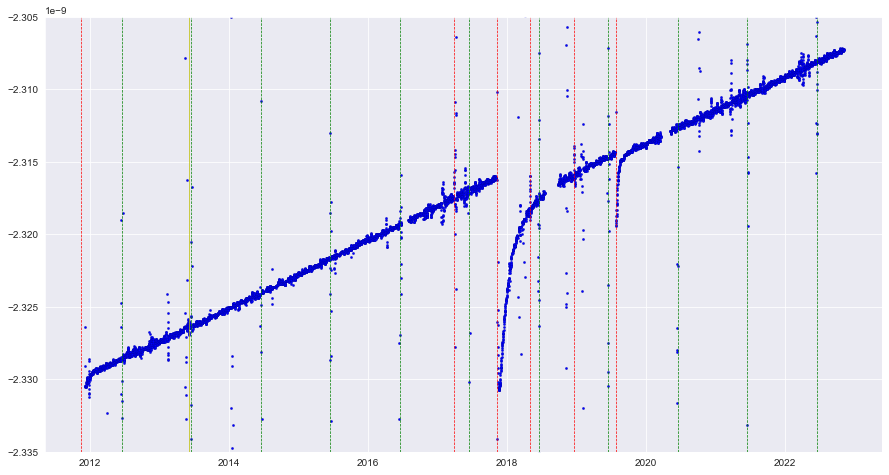

In [53]:
# plot of time derivative of angular frequency. Glicthes in angular frequency are difficult to visualise for crab pulsar
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(Time(out_c[2], format='mjd').datetime, 2*np.pi*out_c[1], 'b.', markersize=5, mew=0.1, mec='k')
for i in [55875.49, 57839.8, 58064.555, 58237.357, 58470.7, 58687.565]: # recorded  glitches (red)
    ax.axvline(Time(i, format='mjd').datetime, ls='--', c='r', lw=0.7)
for i in times[peak_loc]: # closest approach by sun (green)
    ax.axvline(i.datetime, c='g', lw=0.7, ls='--')
ax.axvline(times[1005].datetime, c='y', lw=0.7) # closest approach by jupiter (orange)
ax.set_ylim(-2.335e-9, -2.305e-9)

(1e-06, 0.1)

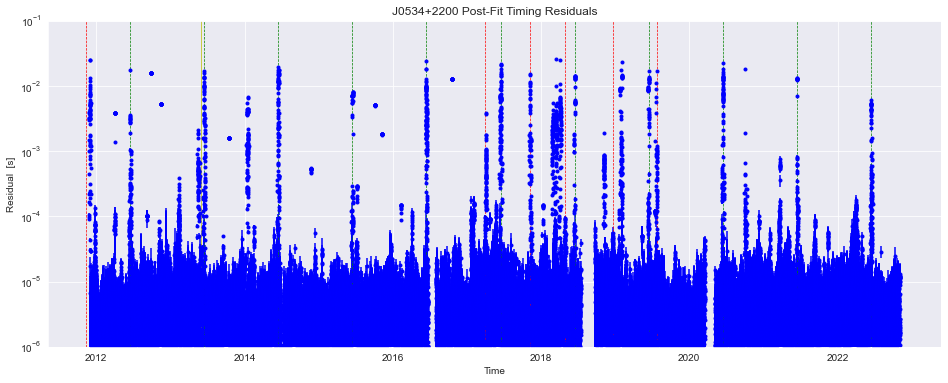

In [58]:
crab_.plot_resids(figsize=(16, 6))
for i in [55875.49, 57839.8, 58064.555, 58237.357, 58470.7, 58687.565]: # recorded  glitches
    plt.axvline(Time(i, format='mjd').datetime, ls='--', c='r', lw=0.7)
for i in times[peak_loc]: # closest approach by sun
    plt.axvline(i.datetime, c='g', lw=0.7, ls='--')
plt.axvline(times[1005].datetime, c='y', lw=0.7) # closest approach by jupiter
plt.yscale('log')
plt.ylim([1e-6, 1e-1])